## Load the Haystack pipeline from Amazon S3 and run inferences - Part 2
---

In this notebook, we will we load the haystack pipeline that is stored in S3 as a `yml` file. Once the haystack pipeline is loaded, we will run a series of questions against the pipeline and measure different metrics, such as latency, accuracy metrics, etc. 

In [1]:
# import libraries
import os
import boto3
import logging
import tempfile
import pandas as pd
import globals as g
from typing import List

In [2]:
!pip install -Uq haystack

In [3]:
# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

Now, we will load the pipeline from the s3 bucket where it was saved as a `yml` file, and then see the contents of the pipeline. We will then run a series of inference requests against the pipeline and measure latency and accuracy metrics

In [4]:
# Initialize the S3 client
s3_client = boto3.client('s3')

# Create temporary file and download pipeline
with tempfile.NamedTemporaryFile(mode='wb', suffix='.yml', delete=False) as tmp_file:
    # Download from the same location where we uploaded
    s3_client.download_fileobj(
        g.HAYSTACK_PIPELINE_BUCKET, 
        g.HAYSTACK_PIPELINE_KEY, 
        tmp_file
    )
    logger.info(f"Downloaded the haystack pipeline from {g.HAYSTACK_PIPELINE_BUCKET}/{g.HAYSTACK_PIPELINE_KEY} to {tmp_file.name}")
    tmp_file_path = tmp_file.name

[2024-11-15 13:41:36,961] p38377 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials
[2024-11-15 13:41:37,498] p38377 {2606389201.py:12} INFO - Downloaded the haystack pipeline from sagemaker-us-east-2-015469603702/pipelines/basic_rag_pipeline.yml to /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmppngowajf.yml


In [5]:
# load the documents stored earlier and get those documents in the doc store
import json
import shutil
from haystack_integrations.document_stores.chroma import ChromaDocumentStore

chroma_persist_path = os.path.join(g.DATA_DIR, "chroma_store")

# Download the zip file
chroma_zip_path = os.path.join(g.DATA_DIR, "chroma_store.zip")
s3_client.download_file(
    g.HAYSTACK_PIPELINE_BUCKET,
    g.CHROMA_DOC_STORE_KEY,
    chroma_zip_path
)

logger.info(f"Downloaded document store from {g.HAYSTACK_PIPELINE_BUCKET}/{g.CHROMA_DOC_STORE_KEY}")

[2024-11-15 13:41:39,832] p38377 {1467797822.py:16} INFO - Downloaded document store from sagemaker-us-east-2-015469603702/pipelines/document_store/chroma_store.zip


In [6]:
chroma_persist_path
os.makedirs(chroma_persist_path, exist_ok=True)

In [7]:
if os.path.exists(chroma_persist_path):
    shutil.rmtree(chroma_persist_path)
shutil.unpack_archive(chroma_zip_path, chroma_persist_path, 'zip')

# Initialize ChromaDB with the restored data
document_store = ChromaDocumentStore(
    persist_path=chroma_persist_path,
    collection_name="documents",
    distance_function="cosine"
)

In [8]:
from haystack import Pipeline
# Now we will load the pipeline from the temporary file path
with open(tmp_file_path, 'r') as file:
    loaded_pipeline = Pipeline.load(file)
    print(f"Loaded the haystack pipeline from {tmp_file_path}")

[2024-11-15 13:41:41,107] p38377 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


Loaded the haystack pipeline from /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmppngowajf.yml


[2024-11-15 13:41:41,507] p38377 {1922383777.py:4} INFO - Loaded Pipeline Structure:


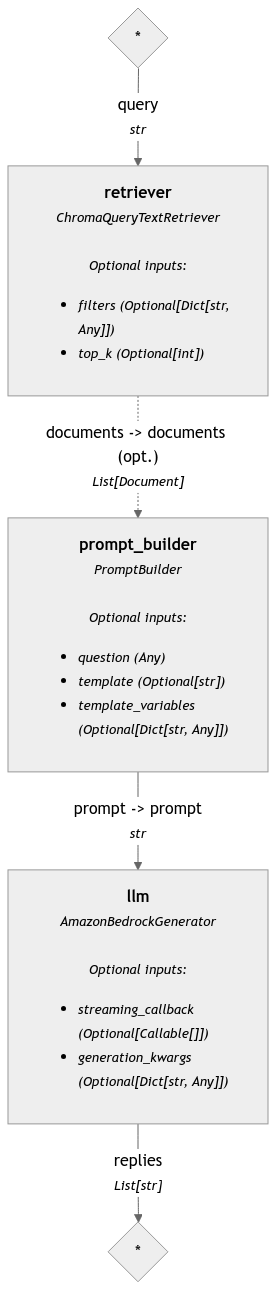

In [9]:
# Now we will clean up the temporary file path and then see the contents of the pipeline
# that we had saved to s3
os.remove(tmp_file_path)
logger.info("Loaded Pipeline Structure:")
loaded_pipeline.show()

#### Update the loaded pipeline with the contents of the doc store stored locally or in `s3`

Now, we will update the loaded pipeline from the `s3` path to contain the doc store contents within it that we saved in the previous notebook.

In [10]:
# use the same embedder
from haystack_integrations.components.embedders.amazon_bedrock import (
    AmazonBedrockDocumentEmbedder,
    AmazonBedrockTextEmbedder,
)

document_embedder = AmazonBedrockTextEmbedder(
    model=g.TITAN_TEXT_EMBED_MODELID,  
    aws_region=g.AWS_REGION          
)

loaded_pipeline.add_component('embedder' , document_embedder)
loaded_pipeline.connect('embedder', 'retriever.query')

[2024-11-15 13:41:49,095] p38377 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


PipelineConnectError: Cannot connect 'embedder.embedding' with 'retriever.query': their declared input and output types do not match.
'embedder':
 - embedding: List[float]
'retriever':
 - query: str (available)

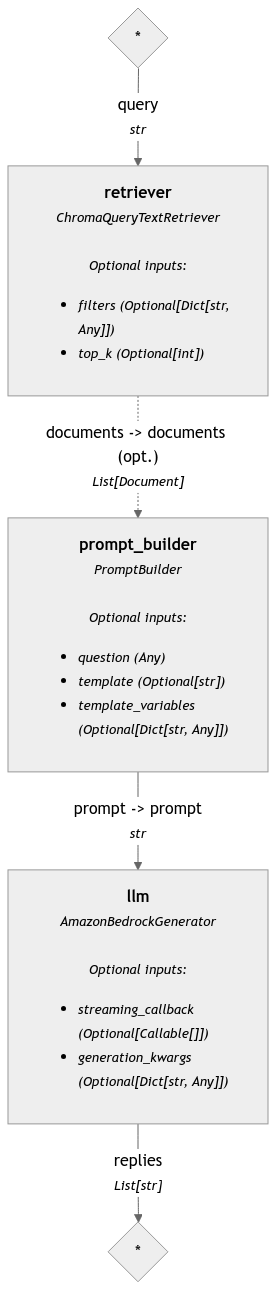

In [ ]:
retriever = loaded_pipeline.get_component("retriever")
# Update the retriever's document store
retriever.document_store = document_store
loaded_pipeline.show()

### Run inferences against the haystack pipeline using Amazon Bedrock
---

Now that we have loaded the pipeline from `s3`, we can run some inferences against this RAG pipeline. As we run inferences, we will measure latency and semantic similarity using the `SASEvaluator` module from haystack.

In [12]:
# Load the dataset that we processed in the first notebook
df = pd.read_csv(os.path.join(g.DATA_DIR, g.PUBMED_QA_CSV_FNAME)) 
df.head()

,instruction,context,response,category
0,Do cC and CXC chemokine levels in children wit...,Chemokines are a superfamily of small peptides...,Initial-phase serum levels of chemokines in pa...,closed_qa
1,Are sAH gene variants associated with obesity-...,The SAH gene locus has recently been proposed ...,We confirm recent evidence that the SAH locus ...,closed_qa
2,Do the functional anatomy of gaze-evoked tinni...,To identify neural sites associated with gaze-...,Patients with GET have plastic changes in mult...,closed_qa
3,Does neighborhood fast-food outlet exposure am...,Greater exposures to fast-food outlets and low...,These findings suggest that efforts to improve...,closed_qa
4,Does conditioned pain modulation predict exerc...,Conditioned pain modulation (CPM) is the conce...,"CPM was attenuated in older adults, as measure...",closed_qa


In [13]:
document_store.filter_documents()

[2024-11-15 13:32:23,863] p35450 {posthog.py:22} INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


[Document(id=b0ed113f8aeaf4a32eb471ce17662234549b3878a4d46a09a95707eb08a00948, content: 'Instruction: Do cC and CXC chemokine levels in children with meningococcal sepsis accurately predict...', meta: {'category': 'closed_qa', 'question': 'Do cC and CXC chemokine levels in children with meningococcal sepsis accurately predict mortality and disease severity?'}),
 Document(id=bcc4a7a5fd909de875f401e32b6a6c218fecad204d366f1eae11f28eb50bad5b, content: 'Instruction: Are sAH gene variants associated with obesity-related hypertension in Caucasians : the ...', meta: {'category': 'closed_qa', 'question': 'Are sAH gene variants associated with obesity-related hypertension in Caucasians : the PEGASE Study?'}),
 Document(id=e9026e45692aab9642a93373dc020e90b7926a91eec705c614440d552ea3a335, content: 'Instruction: Do the functional anatomy of gaze-evoked tinnitus and sustained lateral gaze?
 Context: ...', meta: {'category': 'closed_qa', 'question': 'Do the functional anatomy of gaze-evoked tinnitus 

In [14]:
retriever = loaded_pipeline.get_component("retriever")
document_store = retriever.document_store
doc_count = len(document_store.filter_documents())
print(f"Number of documents in store: {doc_count}")

Number of documents in store: 1000


In [15]:
# run the pipeline and ask a question
question: str = "What is a neurodegenerative disease? Give me examples"
response = loaded_pipeline.run({"retriever": {"query": question}, "prompt_builder": {"question": question}})
print(response["llm"]["replies"][0])

[2024-11-15 13:34:40,214] p35450 {pipeline.py:75} INFO - Running component retriever


InvalidDimensionException: Embedding dimension 384 does not match collection dimensionality 1024

### Measure the `SASEvaluation` score

Now, we will use Haystack's `SAS evaluator` to generate answers to the first 20 questions of the dataset. `SASEvaluator` will evaluate the answer predicted my the pipeline that we have loaded and then compare the semantic similarity to the ground truth provided in the dataset.

In [17]:
from haystack.components.evaluators import SASEvaluator

# Extract the questions and ground truth answers
test_queries = df['instruction'].tolist()
ground_truth_answers = df['response'].tolist()

# Initialize the SAS evaluator
sas_evaluator = SASEvaluator()
sas_evaluator.warm_up()

# Running the pipeline to get predictions
results = []
for question in test_queries:
    # Run the pipeline to get the predicted answer
    response = loaded_pipeline.run({
        "retriever": {"query": question},
        "prompt_builder": {"question": question}
    })
    predicted_answer = response["llm"]["replies"][0]
    results.append(predicted_answer)

# Evaluate the results using SAS evaluator
sas_evaluation = sas_evaluator.run(ground_truth_answers=ground_truth_answers, predicted_answers=results)

# Print the evaluation results
print("Semantic Answer Similarity Evaluation:")
print("Individual scores:", sas_evaluation["individual_scores"])
print("Overall mean SAS score:", sas_evaluation["score"])

# Optionally, print detailed results
print("\nDetailed Results:")
for i, (query, ground_truth, predicted) in enumerate(zip(test_queries, ground_truth_answers, results)):
    print(f"\nQuery {i+1}: {query}")
    print(f"Ground Truth: {ground_truth}")
    print(f"Predicted: {predicted}")
    print(f"SAS Score: {sas_evaluation['individual_scores'][i]}")


[2024-11-15 13:30:40,803] p34644 {config.py:58} INFO - PyTorch version 2.3.0 available.
[2024-11-15 13:30:41,061] p34644 {SentenceTransformer.py:218} INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[2024-11-15 13:30:44,813] p34644 {pipeline.py:75} INFO - Running component retriever


InvalidDimensionException: Embedding dimension 384 does not match collection dimensionality 1024

In [ ]:
# save the evaluation metrics to a csv file
evaluation_data = []
for i, (query, ground_truth, predicted, score) in enumerate(zip(
    test_queries, 
    ground_truth_answers, 
    results, 
    sas_evaluation['individual_scores']
)):
    evaluation_data.append({
        'query_id': i + 1,
        'query': query,
        'ground_truth': ground_truth,
        'predicted_answer': predicted,
        'sas_score': score
    })
df_evaluation = pd.DataFrame(evaluation_data)

# Add the overall mean score as metadata
df_evaluation.attrs['mean_sas_score'] = sas_evaluation['score']

# Display the DataFrame
print("DataFrame Head:")
print(df_evaluation.head())
print(f"\nOverall Mean SAS Score: {df_evaluation.attrs['mean_sas_score']}")

# Save to CSV
csv_fpath_for_initial_eval = os.path.join(g.DATA_DIR, 'evaluation_results_before_dspy.csv')
df_evaluation.to_csv(csv_fpath_for_initial_eval, index=False)
print(f"\nResults saved to {csv_fpath_for_initial_eval}")


DataFrame Head:
   query_id                                              query  \
0         1  Do cC and CXC chemokine levels in children wit...   
1         2  Are sAH gene variants associated with obesity-...   
2         3  Do the functional anatomy of gaze-evoked tinni...   
3         4  Does neighborhood fast-food outlet exposure am...   
4         5  Does conditioned pain modulation predict exerc...   

                                        ground_truth  \
0  Initial-phase serum levels of chemokines in pa...   
1  We confirm recent evidence that the SAH locus ...   
2  Patients with GET have plastic changes in mult...   
3  These findings suggest that efforts to improve...   
4  CPM was attenuated in older adults, as measure...   

                                    predicted_answer  sas_score  
0  Based on the context provided, the key finding...   0.829714  
1  Here are the key points from the summarized re...   0.778862  
2  The key findings regarding the functional anat...